### Imported Libraries

In [1]:
import pandas as pd
import numpy as np
import math as mt
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from utils import *
import datetime as dt
from scipy import stats
from scipy.spatial.distance import pdist
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


### Parameters

In [2]:
# scalability metric used
metric = "response_time_max"
# baseline
dataset = "baseline40-80-jan2022.csv"
# simulation data, for each antipattern there is another file
sdataset = "hiccup-no-stiffle-40-80v1.csv"
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", -1)


/var/folders/2f/bt9wr8zn2g72hblwdfg86zgc0000gn/T/ipykernel_31172/3886375011.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [3]:
spadata = "spadata.csv"
spadatablob = "spadata-blob.csv"
spadatatrucks = "spadata-empty-semi-trucks.csv"
spadataexpensive = "spadata-expensive-db.csv"
spadatastifle = "spadata-stifle.csv"
spadatajam = "spadata-traffic-jam.csv"
spadatacont = "spadata-continuous.csv"
spadatahic = "spadata-hiccups.csv"


### Util Functions

In [4]:
def label_outliers(anomaly_counter):
    """We label as outliner only the rows with anomaly_counter equals to -1"""
    if anomaly_counter == -1:
        return "Outlier"
    else:
        return "Inliner"


In [5]:
def calc_baseline(mean, std):
    """We multiply by 0.6 assuming that the system without queuing has a mean response time 60% lower (T = mean * (1-load))"""
    return mean + 3 * std


In [6]:
def eval_counters(counter, baseline):
    """We compare a measurement with the baseline of a given counter"""
    if counter >= baseline:
        return "Fail"
    else:
        return "Pass"


### Data Extraction

In [7]:
bstatistic_df = pd.read_csv(dataset)
statistic_df = pd.read_csv(sdataset)


In [8]:
spa_df = pd.read_csv(spadata)
spablob_df = pd.read_csv(spadatablob)
spatrucks_df = pd.read_csv(spadatatrucks)
spaexpensive_df = pd.read_csv(spadataexpensive)
spastifle_df = pd.read_csv(spadatastifle)
spajam_df = pd.read_csv(spadatajam)
spacont_df = pd.read_csv(spadatacont)
spahic_df = pd.read_csv(spadatahic)


In [9]:
# only for debugging
# bstatistic_df


In [10]:
# only for debugging
# statistic_df


In [11]:
spa_df


,spa,ndistance,slope
0,Application Hiccups,1.741417,130.421783
1,Continuous Violated Requirements,1.084883,0.000000
2,Traffic Jam,1.718524,260.843565
3,The Stifle,1.600267,80.538172
4,Expensive Database Call,1.592879,334.511603
5,Empty Semi-trucks,1.470761,40.546080
6,The Blob,1.516257,85.674553


In [12]:
# spablob_df


In [13]:
# display the relevant (hiccup) data
# spatrucks_df
# spaexpensive_df
# spastifle_df
# spajam_df
# spacont_df
spahic_df


,Slope,ndistance
0,130.421783,1.599516
1,130.421783,1.608118
2,130.421783,1.620350
3,130.421783,1.639123
4,130.421783,1.671602
5,130.421783,1.741417


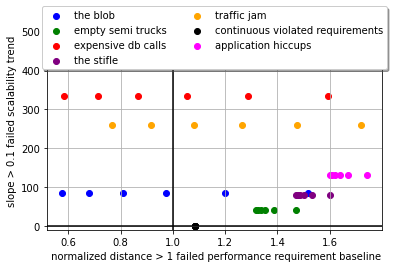

In [14]:
figure = plt.figure
ax = plt.gca()

ax.scatter(spablob_df["ndistance"], spablob_df["Slope"], color="blue", label="the blob")
ax.scatter(spatrucks_df["ndistance"], spatrucks_df["Slope"], color="green", label="empty semi trucks")
ax.scatter(spaexpensive_df["ndistance"], spaexpensive_df["Slope"], color="red", label="expensive db calls")
ax.scatter(spastifle_df["ndistance"], spastifle_df["Slope"], color="purple", label="the stifle")
ax.scatter(spajam_df["ndistance"], spajam_df["Slope"], color="orange", label="traffic jam")
ax.scatter(spacont_df["ndistance"], spacont_df["Slope"], color="black", label="continuous violated requirements")
ax.scatter(spahic_df["ndistance"], spahic_df["Slope"], color="magenta", label="application hiccups")
ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline")
ax.set_ylabel("slope > 0.1 failed scalability trend")
ax.set_ylim(-10, 550)

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)
plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)

plt.grid()


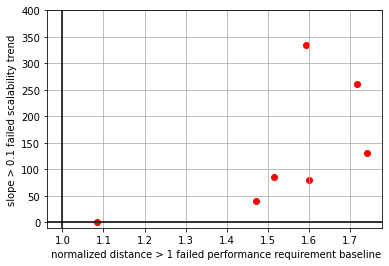

In [15]:
figure = plt.figure
ax = plt.gca()
ax.scatter(spa_df["ndistance"], spa_df["slope"], color="red")


ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline")
ax.set_ylabel("slope > 0.1 failed scalability trend")
ax.set_ylim(-10, 400)

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)
plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line

plt.grid()


### Statistical analysis

In [16]:
# distribution (probability of S)
bstatistic_df["load"].value_counts(normalize=True)


40    0.271804
60    0.182896
70    0.182049
80    0.182049
50    0.181202
Name: load, dtype: float64

In [17]:
# calculate the probability of a giving load
load_probabilities_df = pd.DataFrame(bstatistic_df.groupby(["load"]).instance.count().rename("load_probability"))
load_probabilities_df.load_probability /= load_probabilities_df.load_probability.sum()
lstatistic_df = pd.merge(bstatistic_df, load_probabilities_df, left_on=["load"], right_index=True)


In [18]:
# Calculate probability of executing any of the operations by summing up all operations as
# the denominator and the operation counter as the numerator
probabilities_df = pd.DataFrame(lstatistic_df.groupby(["counter_name"]).instance.count().rename("activation_probability"))
probabilities_df.activation_probability /= probabilities_df.activation_probability.sum()
probabilities_df = probabilities_df.reset_index()
lstatistic_df = pd.merge(lstatistic_df, probabilities_df, on=["counter_name"])


In [19]:
# Baseline calculation and assessment - base statistics
assessment_df = pd.DataFrame(bstatistic_df.groupby(["counter_name"])[metric].agg(["mean", "std"]))
assessment_df["baseline"] = assessment_df.apply(lambda x: calc_baseline(x["mean"], x["std"]), axis=1)
statistic_df = pd.merge(statistic_df, assessment_df[["baseline"]], left_on="counter_name", right_index=True).reset_index(drop=True)
statistic_df["assessment"] = statistic_df.apply(lambda x: eval_counters(x[metric], x["baseline"]), axis=1)

# only for debugging
# statistic_df


In [20]:
# Calculate fraction of successful service execution * the probability activation of the services
s_df = lstatistic_df.groupby(["load", "load_probability", "counter_name", "activation_probability"]).instance.count().rename("s")
s_df = pd.DataFrame(s_df / s_df.groupby(level=[0, 1, 2]).transform("sum"))
s_df = s_df.reset_index()
groupby_dict = {"activation_probability": "s", "s": "s"}
s_df = s_df.set_index(["load", "load_probability", "counter_name"])
s_df = s_df.groupby(groupby_dict, axis=1).prod().reset_index()


In [21]:
s_df.head()


,load,load_probability,counter_name,s
0,40,0.271804,EntryLevelSystemCall.NIS.adjustment,0.055885
1,40,0.271804,EntryLevelSystemCall.NIS.enquiry,0.055885
2,40,0.271804,EntryLevelSystemCall.NIS.interrogation,0.055885
3,40,0.271804,EntryLevelSystemCall.NIS.networkControl,0.055885
4,40,0.271804,NIS.adjustment.DB.read,0.055885


In [22]:
# Add analysis timestamp
statistic_df["analysis_timestamp"] = dt.datetime.today()


In [23]:
# Prepare data for training
lb_detection_df = statistic_df.copy()
lb_detection_df["anomaly"] = pd.Series()
assessment_df


/var/folders/2f/bt9wr8zn2g72hblwdfg86zgc0000gn/T/ipykernel_31172/328003151.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lb_detection_df["anomaly"] = pd.Series()


,mean,std,baseline
counter_name,,,
EntryLevelSystemCall.NIS.adjustment,0.215689,0.046457,0.355060
EntryLevelSystemCall.NIS.enquiry,0.388181,0.111568,0.722886
EntryLevelSystemCall.NIS.interrogation,0.358797,0.130024,0.748869
EntryLevelSystemCall.NIS.networkControl,0.340792,0.118747,0.697033
NIS.adjustment.DB.read,0.077976,0.016345,0.127011
NIS.adjustment.PROC.adjustmentPROC,0.085120,0.005596,0.101909
NIS.enquiry.DB.read,0.084964,0.014816,0.129414
NIS.enquiry.PROC.enquiry,0.373320,0.111420,0.707581
NIS.networkControl.PROC.control,0.321936,0.119437,0.680247


In [24]:
# need to use baseline from bstatistics and max from statistics
# baseline is from bstatistics to metrics is from statistics
df = pd.DataFrame(statistic_df.groupby(["counter_name", "load"]).agg({metric: "max", "baseline": "mean"}))
df.columns.name = None
df = df.reset_index()
df["distance"] = df.baseline - df[metric]
df["ndistance"] = 2 * df[metric] / (df.baseline + df[metric])
df["assessment"] = df.distance.apply(lambda x: False if (x > 0) else True)
df["binary"] = df.distance.apply(lambda x: 0 if (x > 0) else 1)

bs_df = pd.DataFrame(df.groupby(["counter_name"]).binary.sum())

df = pd.merge(df, bs_df, on="counter_name")
df = df.rename(columns={"binary_x": "binary", "binary_y": "sbinary"})

# only for debugging
# df


In [25]:
# only for debugging
# bs_df.binary


In [26]:
# compute slope and concatenate to df
# create slope df
slope_df = df.copy()
slope_df["slope"] = pd.Series()
for service in lb_detection_df.counter_name.unique():
    for counter in lb_detection_df.loc[lb_detection_df.counter_name == service, "counter_name"].unique():
        x = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "load"]
        y = lb_detection_df.loc[(lb_detection_df.counter_name == counter), metric]
        b = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "baseline"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        slope_df.loc[(slope_df.counter_name == counter), "slope"] = slope

# only for debugging
# slope_df


/var/folders/2f/bt9wr8zn2g72hblwdfg86zgc0000gn/T/ipykernel_31172/1300361657.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  slope_df["slope"] = pd.Series()


In [27]:
slope_df.loc[slope_df.load == 80, ["counter_name", "ndistance", "slope"]].to_csv("edb-slope_nd20.csv", index=False)


In [28]:
meas_80_df = slope_df.loc[slope_df.load == 80, ["counter_name", "ndistance", "slope"]]

# only for debugging
# meas_80_df


In [29]:
full_meas_80_df = slope_df.loc[slope_df.load == 80, ["ndistance", "slope", "counter_name", "assessment"]]


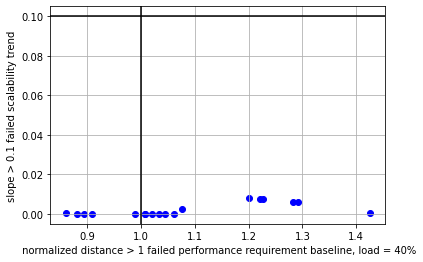

In [30]:
ax = plt.gca()
ax.scatter(meas_80_df["ndistance"], meas_80_df["slope"], color="blue")
ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline, load = 40%")
ax.set_ylabel("slope > 0.1 failed scalability trend")

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)

plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line
plt.grid()


/var/folders/2f/bt9wr8zn2g72hblwdfg86zgc0000gn/T/ipykernel_31172/2746756678.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  spa_t_df["index"] = pd.Series()


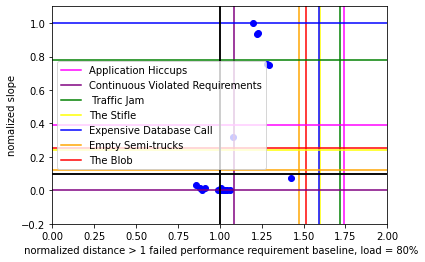

In [31]:
# plot with vertical lines per SPA

ax = plt.gca()
ax.scatter(meas_80_df["ndistance"], (meas_80_df["slope"] / meas_80_df["slope"].max()), color="blue")

ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline, load = 80%")
ax.set_ylabel("nomalized slope")

# prepare data for training
spa_t_df = spa_df.copy()
spa_t_df["index"] = pd.Series()
max = spa_t_df["slope"].max()
plt.axvline(spa_t_df["ndistance"][0], color="magenta", label=spa_t_df["spa"][0])
plt.axvline(spa_t_df["ndistance"][1], color="purple", label=spa_t_df["spa"][1])
plt.axvline(spa_t_df["ndistance"][2], color="green", label=spa_t_df["spa"][2])
plt.axvline(spa_t_df["ndistance"][3], color="yellow", label=spa_t_df["spa"][3])
plt.axvline(spa_t_df["ndistance"][4], color="blue", label=spa_t_df["spa"][4])
plt.axvline(spa_t_df["ndistance"][5], color="orange", label=spa_t_df["spa"][5])
plt.axvline(spa_t_df["ndistance"][6], color="red", label=spa_t_df["spa"][6])
plt.axhline((spa_t_df["slope"][0] / spa_t_df["slope"].max()), color="magenta")
plt.axhline((spa_t_df["slope"][1] / spa_t_df["slope"].max()), color="purple")
plt.axhline((spa_t_df["slope"][2] / spa_t_df["slope"].max()), color="green")
plt.axhline((spa_t_df["slope"][3] / spa_t_df["slope"].max()), color="yellow")
plt.axhline((spa_t_df["slope"][4] / spa_t_df["slope"].max()), color="blue")
plt.axhline((spa_t_df["slope"][5] / spa_t_df["slope"].max()), color="orange")
plt.axhline((spa_t_df["slope"][6] / spa_t_df["slope"].max()), color="red")

ax.set_ylim(-0.2, 1.1)
ax.set_xlim(0, 2)

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)
plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line
majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)

plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)

plt.legend()
plt.show()


In [32]:
spa_t_df


,spa,ndistance,slope,index
0,Application Hiccups,1.741417,130.421783,NaN
1,Continuous Violated Requirements,1.084883,0.000000,NaN
2,Traffic Jam,1.718524,260.843565,NaN
3,The Stifle,1.600267,80.538172,NaN
4,Expensive Database Call,1.592879,334.511603,NaN
5,Empty Semi-trucks,1.470761,40.546080,NaN
6,The Blob,1.516257,85.674553,NaN


/var/folders/2f/bt9wr8zn2g72hblwdfg86zgc0000gn/T/ipykernel_31172/1384464301.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  spa_t_df["index"] = pd.Series()


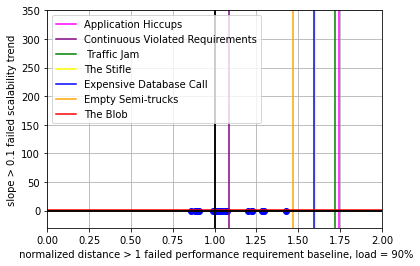

In [33]:
# plot with vertical lines per SPA

ax = plt.gca()
ax.scatter(meas_80_df["ndistance"], meas_80_df["slope"], color="blue")


ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline, load = 90%")
ax.set_ylabel("slope > 0.1 failed scalability trend")

# Prepare data for training
spa_t_df = spa_df.copy()
spa_t_df["index"] = pd.Series()
max = spa_t_df["slope"].max()
plt.axvline(spa_t_df["ndistance"][0], color="magenta", label=spa_t_df["spa"][0])
plt.axvline(spa_t_df["ndistance"][1], color="purple", label=spa_t_df["spa"][1])
plt.axvline(spa_t_df["ndistance"][2], color="green", label=spa_t_df["spa"][2])
plt.axvline(spa_t_df["ndistance"][3], color="yellow", label=spa_t_df["spa"][3])
plt.axvline(spa_t_df["ndistance"][4], color="blue", label=spa_t_df["spa"][4])
plt.axvline(spa_t_df["ndistance"][5], color="orange", label=spa_t_df["spa"][5])
plt.axhline(spa_t_df["ndistance"][6], color="red", label=spa_t_df["spa"][6])

ax.set_ylim(-30, 350)
ax.set_xlim(0, 2)

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)
plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line
majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)

plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)
plt.legend()
plt.grid()


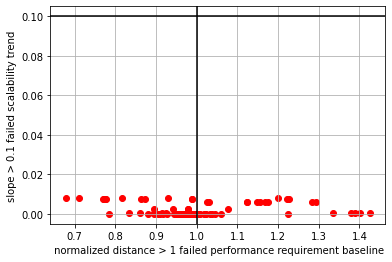

In [34]:
figure = plt.figure
ax = plt.gca()
ax.scatter(slope_df["ndistance"], slope_df["slope"], color="red")
ax.set_xlabel(" normalized distance > 1 failed performance requirement baseline")
ax.set_ylabel("slope > 0.1 failed scalability trend")

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter("%d")
minorLocator = MultipleLocator(1)

plt.axhline(0.1, color="black")  # horizontal line
plt.axvline(1, color="black")  # vertical line
plt.grid()


In [35]:
# only for debugging
# slope_df


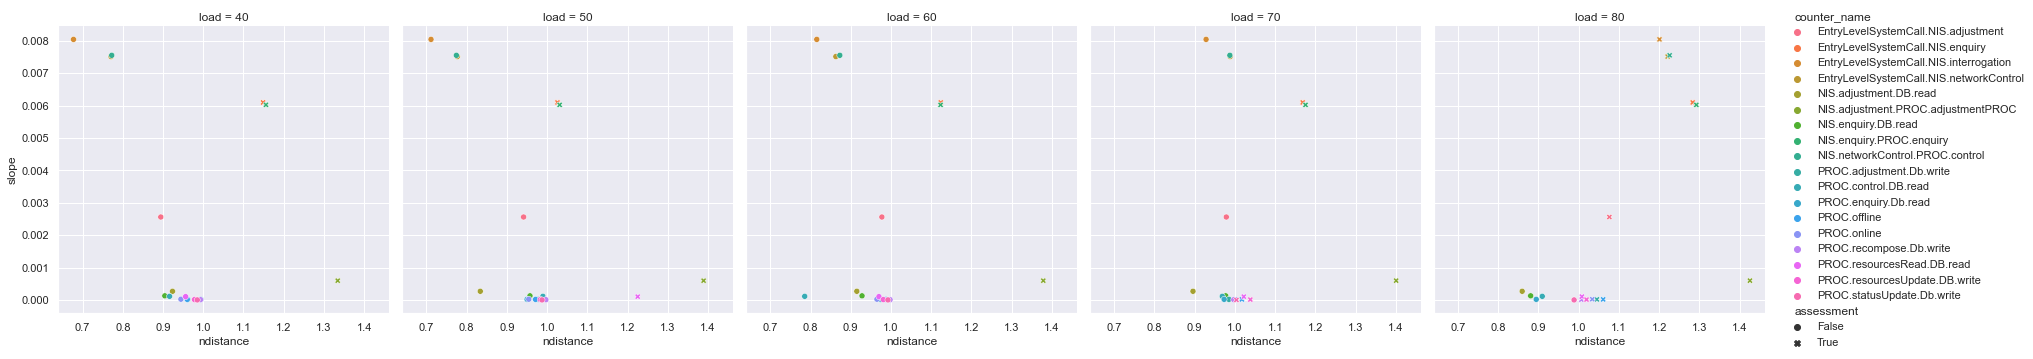

In [36]:
sns.set()
g = sns.relplot(x="ndistance", y="slope", hue="counter_name", data=slope_df, style="assessment", col="load")

plt.savefig("hiccup-sens20.pdf")


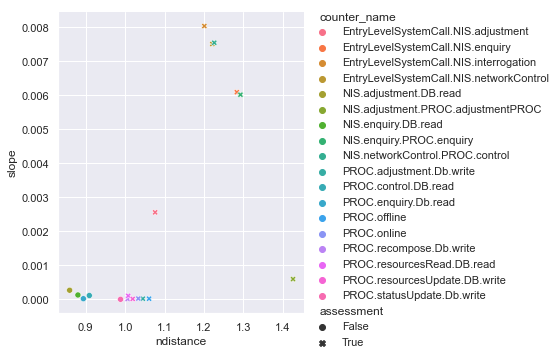

In [37]:
# full_meas_90_df
sns.set()
sns.relplot(x="ndistance", y="slope", hue="counter_name", style="assessment", data=full_meas_80_df, legend="full")
plt.savefig("hiccup-40-80load80-0821.pdf")


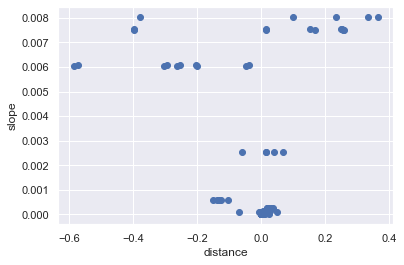

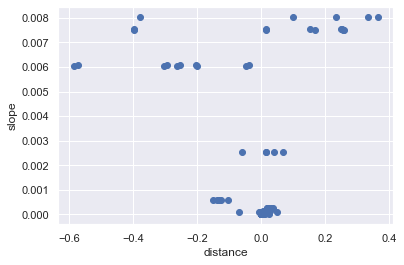

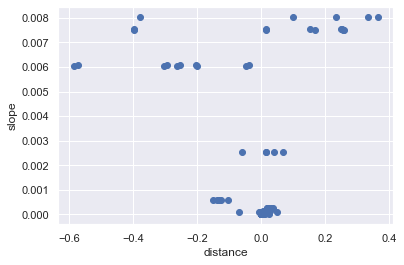

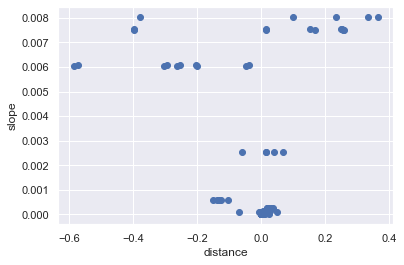

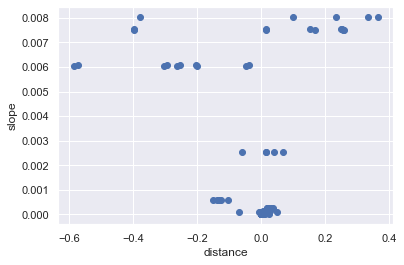

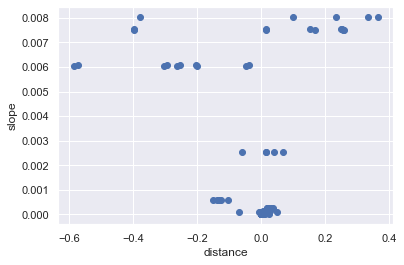

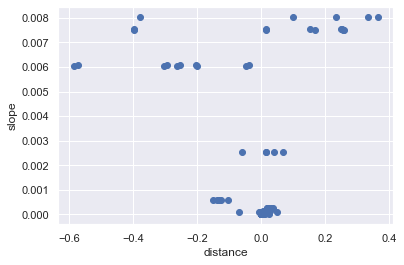

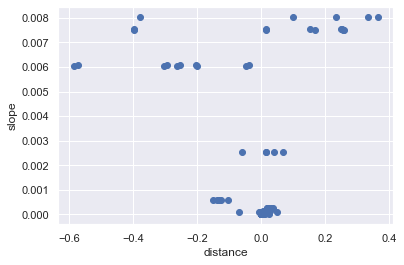

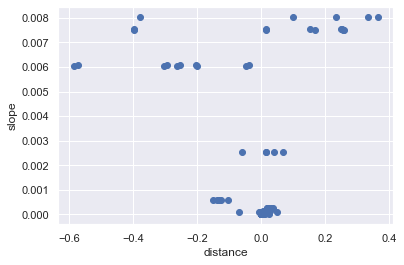

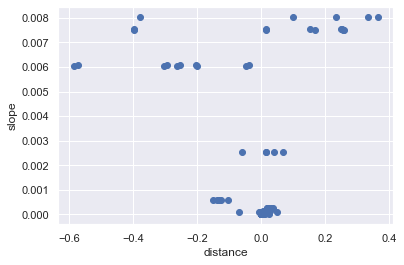

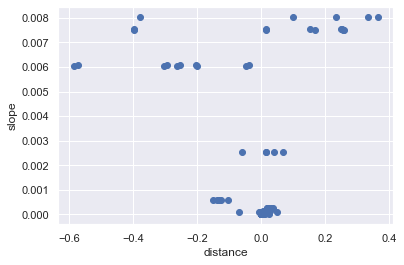

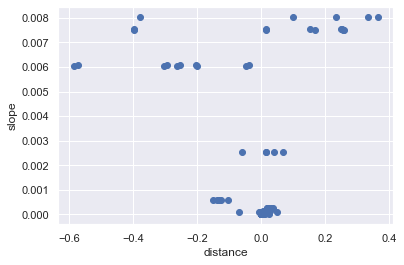

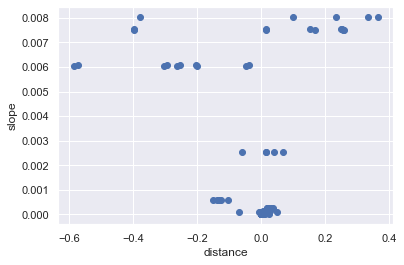

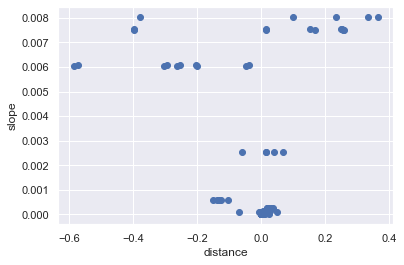

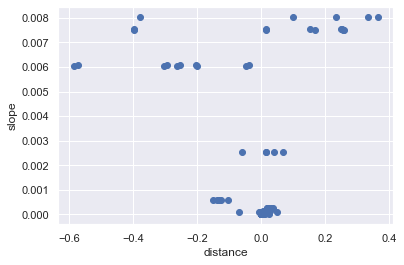

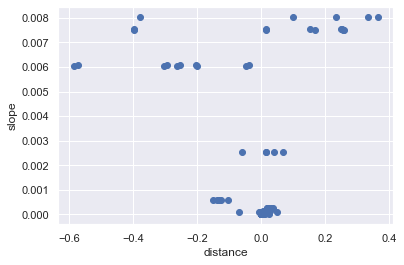

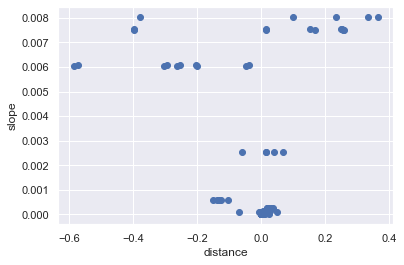

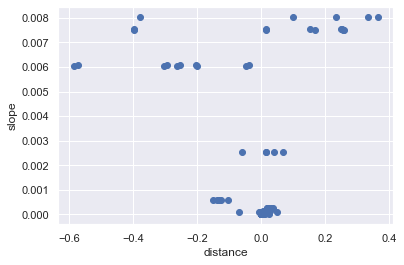

In [38]:
# distances and plot slope vs. distance
for service in lb_detection_df.counter_name.unique():
    for counter in lb_detection_df.loc[lb_detection_df.counter_name == service, "counter_name"].unique():
        figure = plt.figure
        ax = plt.gca()
        ax.scatter(slope_df["distance"], slope_df["slope"])
        ax.set_xlabel("distance")
        ax.set_ylabel("slope")
    plt.show()


In [39]:
failed_distance_df = pd.DataFrame(df.groupby(["counter_name"]).assessment.any())
failed_distance_df.columns.name = None
failed_distance_df = failed_distance_df.reset_index()
failed_distance_df


,counter_name,assessment
0,EntryLevelSystemCall.NIS.adjustment,True
1,EntryLevelSystemCall.NIS.enquiry,True
2,EntryLevelSystemCall.NIS.interrogation,True
3,EntryLevelSystemCall.NIS.networkControl,True
4,NIS.adjustment.DB.read,False
5,NIS.adjustment.PROC.adjustmentPROC,True
6,NIS.enquiry.DB.read,False
7,NIS.enquiry.PROC.enquiry,True
8,NIS.networkControl.PROC.control,True
9,PROC.adjustment.Db.write,True


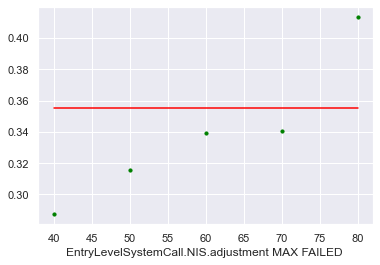

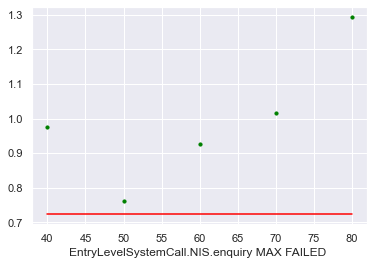

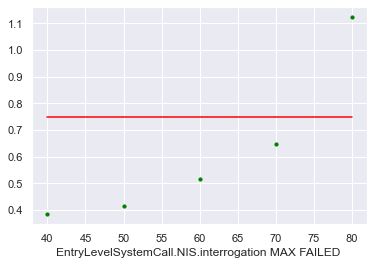

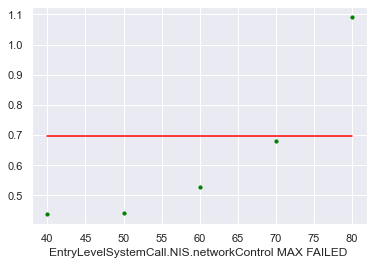

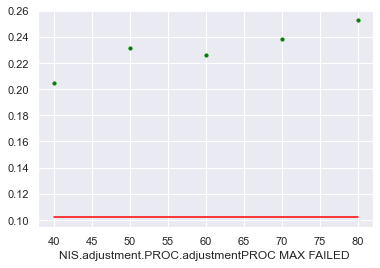

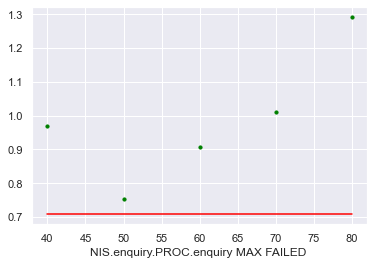

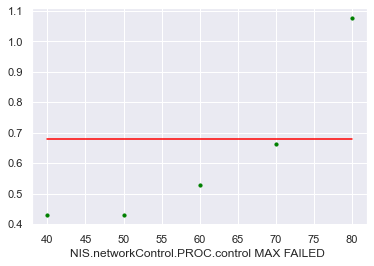

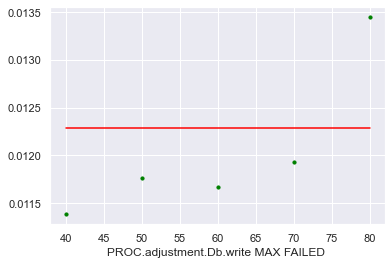

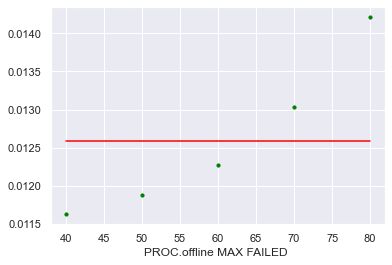

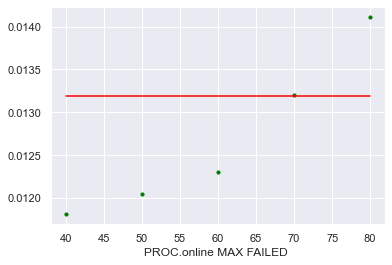

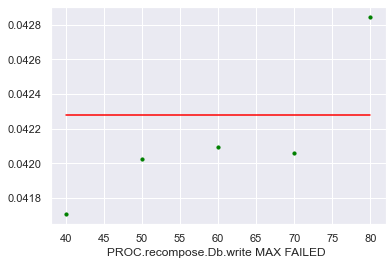

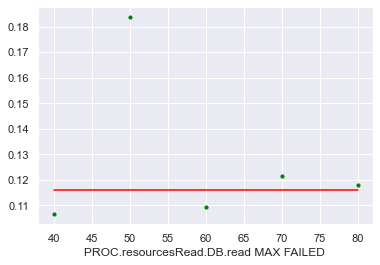

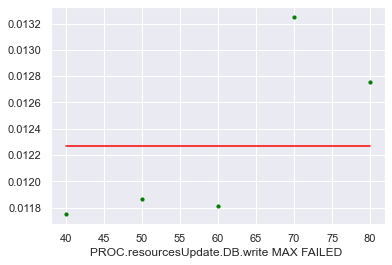

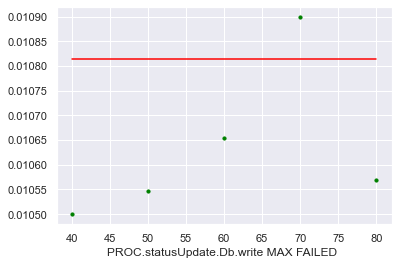

In [40]:
for counter in failed_distance_df.loc[failed_distance_df.assessment == True, "counter_name"].values:
    plt.figure()
    x = df.loc[df.counter_name == counter, "load"]
    y = df.loc[df.counter_name == counter, metric]
    b = df.loc[df.counter_name == counter, "baseline"]
    plt.xlabel(str(counter) + " MAX FAILED ")
    plt.scatter(x, y, s=10, color="green")
    plt.plot(x, b, color="red", label="baseline")


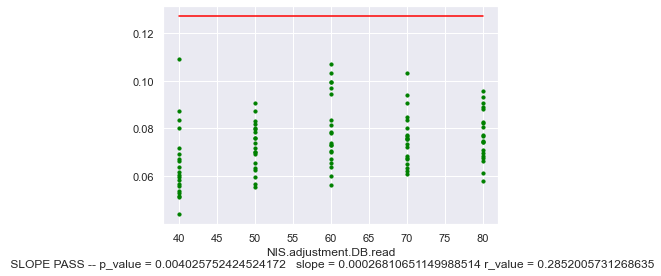

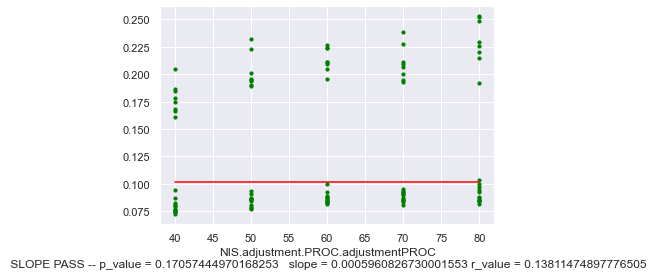

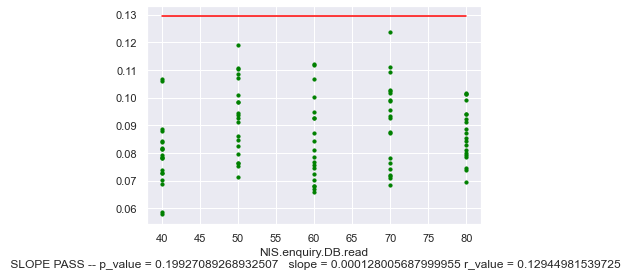

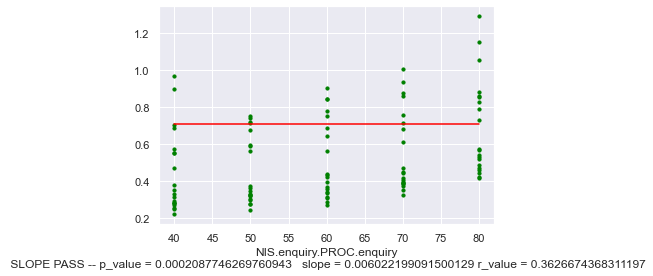

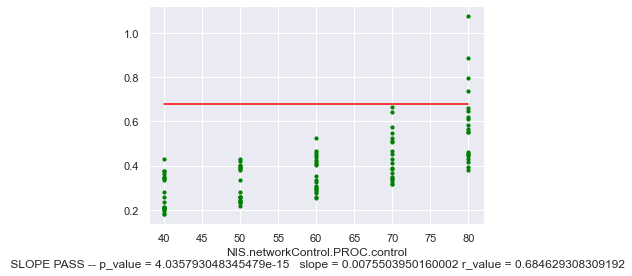

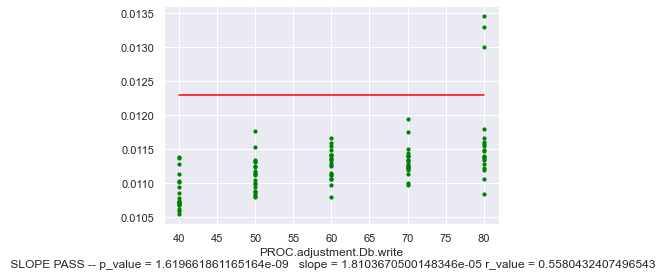

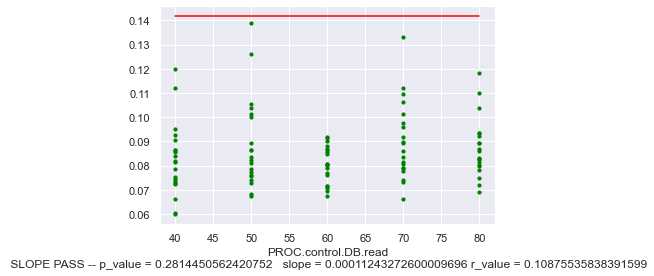

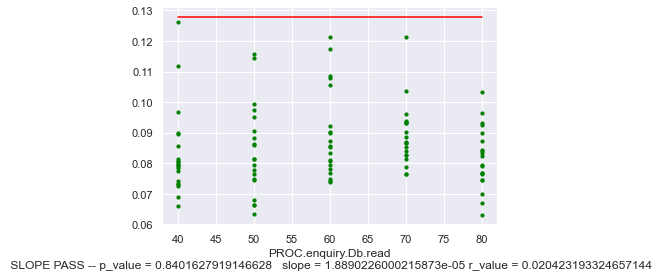

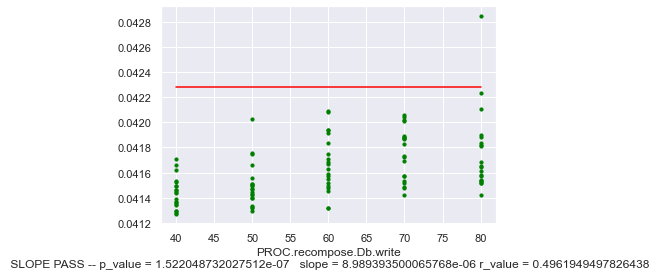

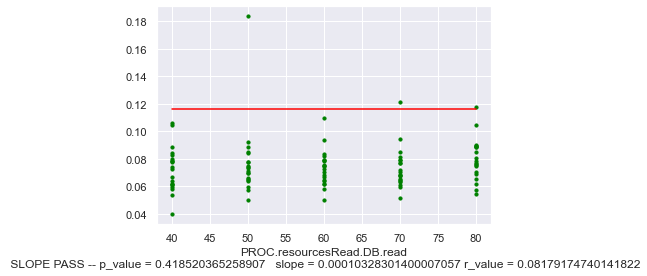

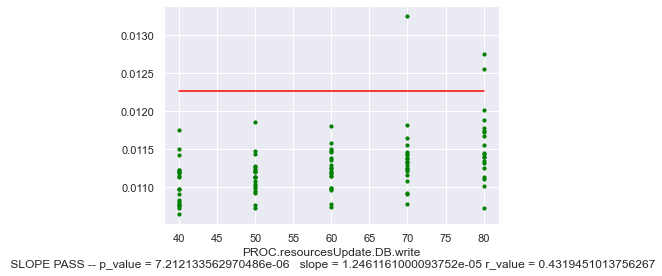

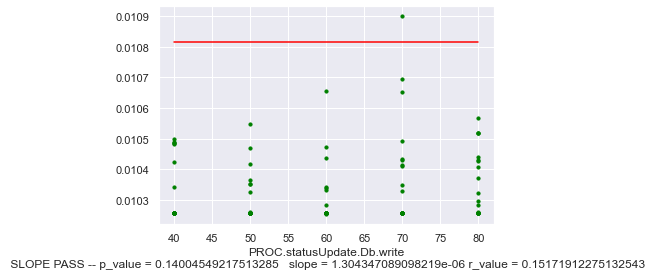

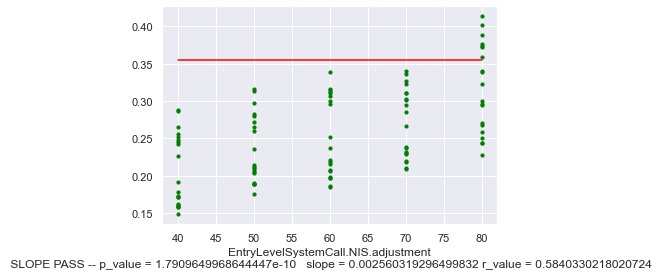

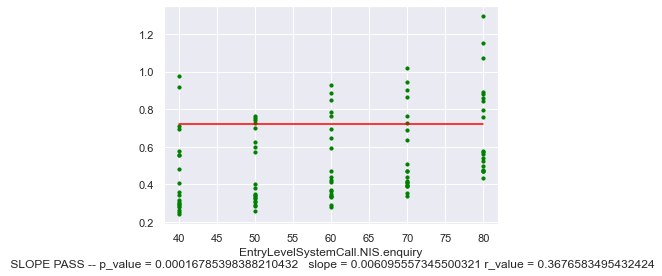

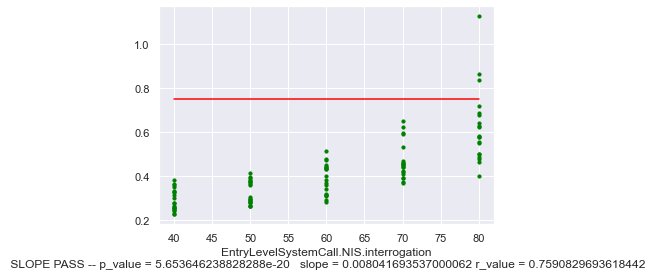

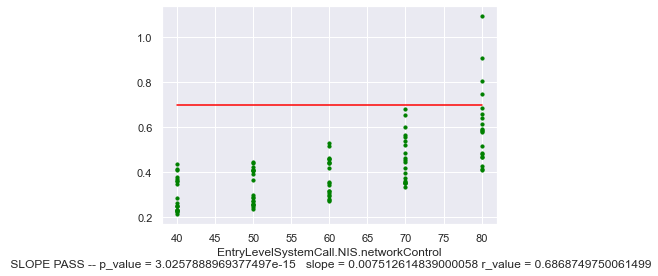

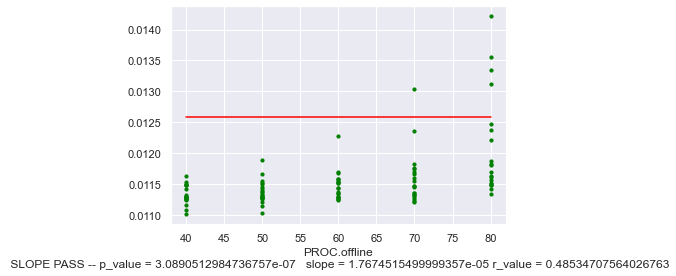

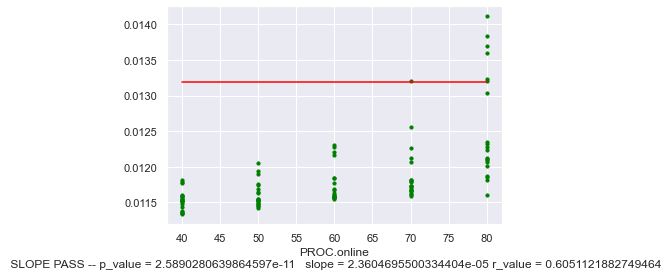

In [42]:
# Train models (one per counter, load as the second dimension of the anomaly detection process)
for service in lb_detection_df.counter_name.unique():
    for counter in lb_detection_df.loc[lb_detection_df.counter_name == service, "counter_name"].unique():
        x = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "load"]
        y = lb_detection_df.loc[(lb_detection_df.counter_name == counter), metric]
        b = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "baseline"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # print("counter = " + str(counter) + " slope = " + str(slope))
        if slope < 0.01:
            plt.figure()
            # print("p_value = " + str(p_value))
            # print("slope = " + str(slope))
            # print("intercept = " + str(intercept))
            # print("r_value = " + str(r_value))
            # print("std_err = " + str(std_err))
            x = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "load"]
            y = lb_detection_df.loc[(lb_detection_df.counter_name == counter), metric]
            plt.xlabel(str(counter) + "\n SLOPE PASS -- p_value = " + str(p_value) + "   slope = " + str(slope) + " r_value = " + str(r_value))
            plt.scatter(x, y, s=10, color="green")
            plt.plot(x, b, color="red", label="baseline")

        if slope >= 0.01:  
            plt.figure()
            x = lb_detection_df.loc[(lb_detection_df.counter_name == counter), "load"]
            y = lb_detection_df.loc[(lb_detection_df.counter_name == counter), metric]
            plt.xlabel(str(counter) + "\n SLOPE FAIL p_value = " + str(p_value) + "   slope = " + str(slope) + " r_value = " + str(r_value))
            plt.scatter(x, y, s=10, color="green")
            plt.plot(x, b, color="red", label="baseline")
